In [7]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Gnostic Boosting Regressor

### **Overview**
The **Machine Gnostics Boosting Regressor** leverages the predictive power of Gradient Boosting (XGBoost) while ensuring robustness against outliers through **Gnostic Weighted Learning**.

Gradient boosting is highly effective at minimizing loss, but standard loss functions (like MSE) are sensitive to outliers. The Gnostic variant iteratively identifies these outliers—samples that are thermodynamically inconsistent with the majority—and down-weights them, allowing the boosting model to focus on the true signal.

Key advantages:
- **State-of-the-Art Precision**: Extends XGBoost for high-performance regression.
- **Robustness**: Ignored extreme outliers that would skew standard models.
- **Gnostic Diagnostics**: Provides interpretable weights indicating sample reliability.
- **Iterative Improvement**: Refines the model through the Ideal Gnostic Cycle.

---

### **Theoretical Background**

The algorithm follows this cycle:
1.  **Boosting Step**: An XGBoost regressor minimizes error on the current weighted dataset.
2.  **Gnostic Step**: Residuals are analyzed to compute Gnostic Entropy. High entropy (unexpectedly large error) leads to lower sample probability weights.
3.  **Update**: Weights are updated, and the boosting model is retrained (or refined) to fit the "clean" data distribution better.

***

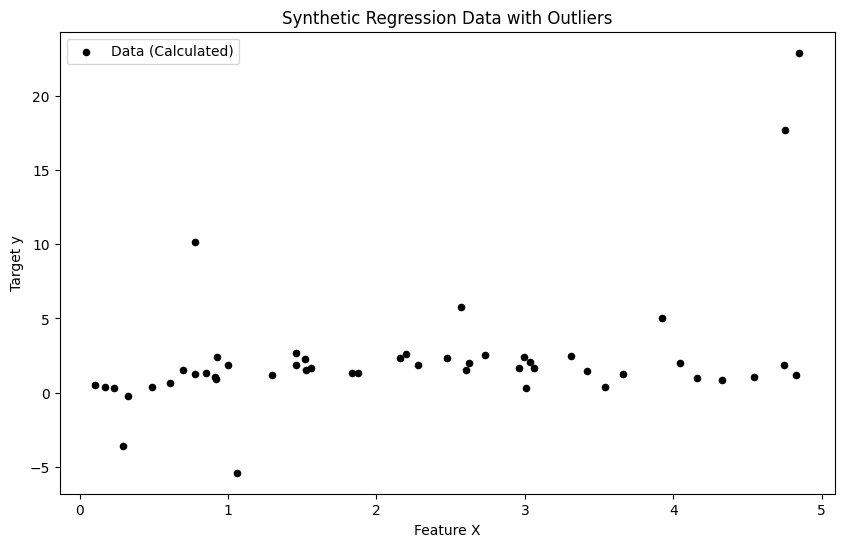

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import GnosticBoostingRegressor

# Custom data generation function (No sklearn)
def generate_regression_data(n_samples=200, outlier_ratio=0.15, noise_level=0.5, random_state=42):
    rng = np.random.RandomState(random_state)
    
    # Generate X values
    X = np.sort(5 * rng.rand(n_samples, 1), axis=0)
    
    # Generate true function (e.g., sin(x) + linear trend)
    y = np.sin(X).ravel() + 0.5 * X.ravel()
    
    # Add Gaussian noise
    y += noise_level * rng.randn(n_samples)
    
    # Add outliers
    n_outliers = int(n_samples * outlier_ratio)
    outlier_indices = rng.choice(n_samples, n_outliers, replace=False)
    
    # Shift outliers far away from the true function
    y[outlier_indices] += 8 * rng.randn(n_outliers) + 10 * np.sign(rng.randn(n_outliers))
    
    return X, y

# Generate data
X, y = generate_regression_data(n_samples=50, outlier_ratio=0.2)

# Visualize proper vs contaminated data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', s=20, label='Data (Calculated)')
plt.title("Synthetic Regression Data with Outliers")
plt.xlabel("Feature X")
plt.ylabel("Target y")
plt.legend()
plt.show()

In [21]:
# Initialize Gnostic Boosting Regressor
# We pass base XGBoost parameters via kwargs if needed (e.g. n_estimators, max_depth)
model = GnosticBoostingRegressor(
    max_iter=5, 
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    verbose=True
)

# Fit the model
print("Training Gnostic Boosting Regressor...")
model.fit(X, y)

# Predict
y_pred = model.predict(X)

2026-01-30 17:56:46,525 | GnosticBoostingRegressor | INFO | GnosticBoostingRegressor initialized.
2026-01-30 17:56:46,526 | GnosticBoostingRegressor | INFO | HistoryBoostingBase initialized.
2026-01-30 17:56:46,529 | GnosticBoostingRegressor | INFO | Starting fit process for GnosticBoostingRegressor.
2026-01-30 17:56:46,529 | GnosticBoostingRegressor | INFO | Starting fit input/output processing.
2026-01-30 17:56:46,530 | GnosticBoostingRegressor | INFO | Checking input X of type: <class 'numpy.ndarray'>
2026-01-30 17:56:46,530 | GnosticBoostingRegressor | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2026-01-30 17:56:46,530 | GnosticBoostingRegressor | INFO | Checking target y of type: <class 'numpy.ndarray'>
2026-01-30 17:56:46,531 | GnosticBoostingRegressor | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2026-01-30 17:56:46,531 | GnosticBoostingRegressor | INFO | Starting fit process for BoostingCalBase.


Training Gnostic Boosting Regressor...


2026-01-30 17:56:46,848 | GnosticBoostingRegressor | INFO | Iteration 1: Loss 0.00018365906423853623, Rentropy 0.08967532343185326
2026-01-30 17:56:47,007 | GnosticBoostingRegressor | INFO | Iteration 2: Loss 40.89435137622474, Rentropy 0.06746835824937877
2026-01-30 17:56:47,167 | GnosticBoostingRegressor | INFO | Iteration 3: Loss 40.20242018770136, Rentropy 0.05950146300282792
2026-01-30 17:56:47,318 | GnosticBoostingRegressor | INFO | Iteration 4: Loss 40.27396694147485, Rentropy 0.05612496913738982
2026-01-30 17:56:47,462 | GnosticBoostingRegressor | INFO | Iteration 5: Loss 40.94062759320443, Rentropy 0.06519017987350333
2026-01-30 17:56:47,463 | GnosticBoostingRegressor | INFO | Making predictions with GnosticBoostingRegressor.
2026-01-30 17:56:47,463 | GnosticBoostingRegressor | INFO | Starting predict input/output processing.
2026-01-30 17:56:47,463 | GnosticBoostingRegressor | INFO | Checking input X for prediction of type: <class 'numpy.ndarray'>
2026-01-30 17:56:47,463 | Gn

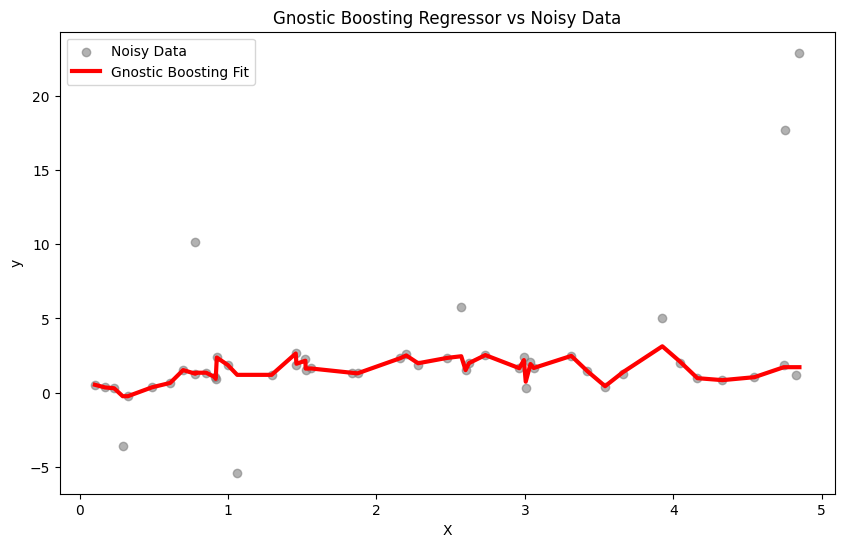

In [22]:
# Sort X for cleaner line plotting
sort_idx = np.argsort(X, axis=0).flatten()
X_sorted = X[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='gray', alpha=0.6, label='Noisy Data')
plt.plot(X_sorted, y_pred_sorted, color='red', linewidth=3, label='Gnostic Boosting Fit')
plt.title("Gnostic Boosting Regressor vs Noisy Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

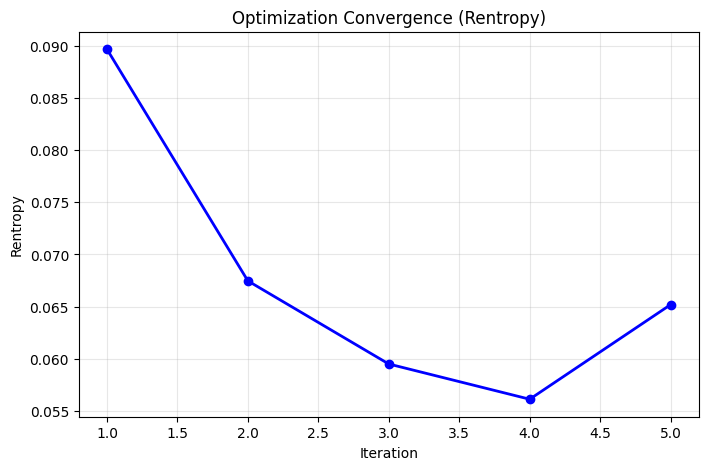

Initial Rentropy: None
Final Rentropy: 0.06519017987350333


In [23]:
history = model._history

if len(history) > 1:
    iterations = [h['iteration'] for h in history if h['iteration'] is not None]
    
    # Plot loss or rentropy
    if 'rentropy' in history[1]:
        metric = 'rentropy'
        title = 'Rentropy'
    else:
        metric = 'cross_entropy_loss'
        title = 'Loss'
        
    values = [h.get(metric, np.nan) for h in history if h['iteration'] is not None]
    
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, values, 'b-o', linewidth=2)
    plt.title(f'Optimization Convergence ({title})')
    plt.xlabel('Iteration')
    plt.ylabel(title)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial {title}: {values[0]}")
    print(f"Final {title}: {values[-1]}")
else:
    print("Model converged in 1 iteration or history not available.")